### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Таргеты:

1. $$ - \frac{dL(a(x_i), y_i)}{da(x_i)} = 2(y_i - a(x_i)) $$

2. $$ - \frac{dL(a(x_i), y_i)}{da(x_i)} = y_iexp(-a(x_i)y_i) $$

3. $$ - \frac{dL(a(x_i), y_i)}{da(x_i)} = \frac{y_iexp(-a(x_i)y_i)}{1 + exp(-a(x_i)y_i)} = \frac{y_i}{1 + exp(a(x_i)y_i)} $$


##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=50, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def __grad(self, X, y):
        grad = 0
        if self.loss == 'mse':
            grad = 2.0*(y - self.predict(X))
        elif self.loss == 'exp':
            grad = y*np.exp(-self.predict(X)*y)
        elif self.loss == 'log':
            grad = y/(1 + np.exp(self.predict(X)*y))
        return grad
        
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.models = []
        if init_model is None:
            model = base_model(*self.args, **self.kwargs)
            self.models.append(model)
        else:
            model = init_model()
            self.models.append(model)
        self.models[0].fit(X, y)
        feat_num = int(X.shape[1] * self.colsample)
        obj_num = int(X.shape[0] * self.subsample)
        self.features = np.zeros((self.n_estimators + 1, feat_num), dtype=int)
        for i in range (1, self.n_estimators + 1):
            idx = np.random.choice(X.shape[0], obj_num, replace=False)
            self.features[i] = np.random.choice(X.shape[1], feat_num, replace=False)
            X_train = X[idx]
            y_train = self.__grad(X_train, y[idx])
            model = base_model(*self.args, **self.kwargs)
            model.fit(X_train[:, self.features[i]], y_train)
            self.models.append(model)
        
    def predict(self, X):
        res = self.models[0].predict(X)
        for i in range(1, len(self.models)):
            X_pred = X[:, self.features[i]]
            res = res + self.learning_rate * self.models[i].predict(X_pred)
        return np.rint(res)



In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
n_est = [50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
y_vals = []

for n in n_est:
    clf = MyGradientBoostingClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = accuracy_score(y_test, pred)
    y_vals.append(score)

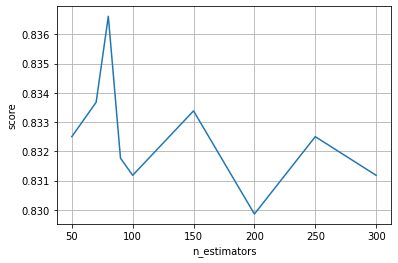

In [10]:
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.plot(n_est, y_vals)
plt.grid(True)

Оптимальное значение параметра n_estimators: 80

In [11]:
losses = ['mse', 'exp', 'log']
results = []

for l in losses:
    clf = MyGradientBoostingClassifier(loss=l)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = accuracy_score(y_test, pred)
    results.append((l, score))

results

[('mse', 0.8355842630651791),
 ('exp', 0.49192601291837934),
 ('log', 0.49236641221374045)]

Оптимальная функция потерь: MSE

In [12]:
rates = [0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
y_vals = []

for r in rates:
    clf = MyGradientBoostingClassifier(learning_rate=r)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = accuracy_score(y_test, pred)
    y_vals.append(score)

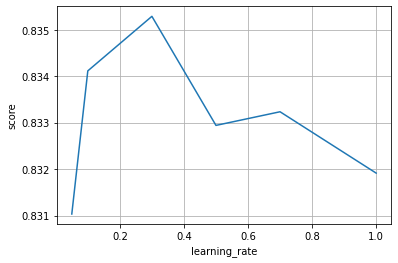

In [13]:
plt.ylabel("score")
plt.xlabel("learning_rate")
plt.plot(rates, y_vals)
plt.grid(True)

Оптимальное значение параметра learning_rate: 0.3

In [14]:
colsamples = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_vals = []

for c in colsamples:
    clf = MyGradientBoostingClassifier(colsample=c)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = accuracy_score(y_test, pred)
    y_vals.append(score)

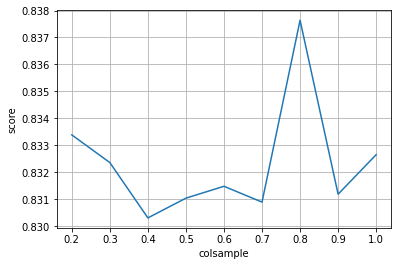

In [15]:
plt.ylabel("score")
plt.xlabel("colsample")
plt.plot(colsamples, y_vals)
plt.grid(True)

Оптимальное значение параметра colsample: 0.8

In [17]:
subsamples = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_vals = []

for s in subsamples:
    clf = MyGradientBoostingClassifier(subsample=s)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = accuracy_score(y_test, pred)
    y_vals.append(score)

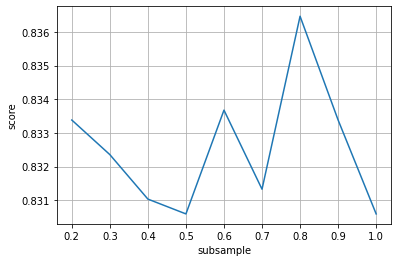

In [18]:
plt.ylabel("score")
plt.xlabel("subsample")
plt.plot(subsamples, y_vals)
plt.grid(True)

Оптимальное значение параметра subsample: 0.8

Модель с лучшими параметрами:

In [19]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.3, n_estimators=80, colsample=0.8, subsample=0.8)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.836318261890781

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.3, n_estimators=80, colsample=0.8, subsample=0.8)
clf.fit(X_train, y_train, base_model=RandomForestRegressor)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.8772753963593658

Качество улучшилось.

In [22]:
pred = np.zeros(y_test.shape)
for i in range(30):
    idx = np.random.randint(0, X_train.shape[0], X_train.shape[0] // 30)
    clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.3, n_estimators=80, colsample=0.8, subsample=0.8)
    clf.fit(X_train[idx], y_train[idx])
    pred += clf.predict(X_test)
pred[pred < 15] = 0
pred[pred >= 15] = 1
accuracy_score(y_test, pred)

0.8518790369935408

Качество улучшилось.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [24]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.3, n_estimators=80, colsample=0.8, subsample=0.8)
clf.fit(X_train, y_train, init_model=LinearRegression)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.7884615384615384

In [25]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.3, n_estimators=80, colsample=0.8, subsample=0.8)
clf.fit(X_train, y_train, init_model=SVC)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.7583675866118614

In [26]:
clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.3, n_estimators=80, colsample=0.8, subsample=0.8)
clf.fit(X_train, y_train, init_model=RandomForestClassifier)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.8827069876688197

Линейная регрессия и SVM дают точность хуже, при этом SVM еще и считается очень долго, а вот случайный лес значительно улучшает результат.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

